In [3]:
import pywt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima.arima import auto_arima, arima
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Using TensorFlow backend.


In [4]:
Data = pd.read_csv('AMZN.csv', header=0, usecols=['Date', 'Close'], parse_dates=True, index_col='Date')
Data.index = pd.to_datetime(Data.index)

In [5]:
display(Data.head())
display(Data.describe())

,Close
Date,
2000-06-05,54.5000
2000-06-06,50.5625
2000-06-07,51.8125
2000-06-08,51.8750
2000-06-09,52.1875


,Close
count,4529.000000
mean,243.952496
std,323.696425
min,5.970000
25%,38.740002
50%,87.269997
75%,306.540009
max,1696.349976


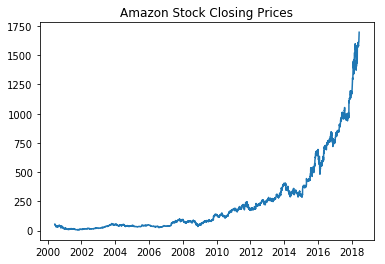

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4529 entries, 2000-06-05 to 2018-06-05
Data columns (total 1 columns):
Close    4529 non-null float64
dtypes: float64(1)
memory usage: 70.8 KB


None

In [6]:
plt.figure()
plt.title('Amazon Stock Closing Prices')
plt.plot(Data)
plt.show()

display(Data.info())

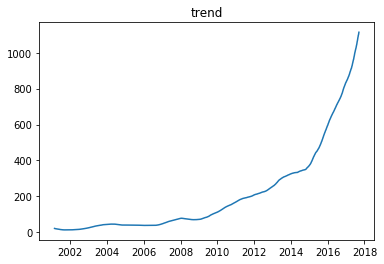

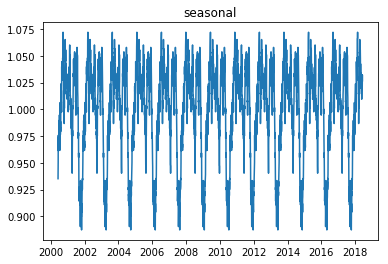

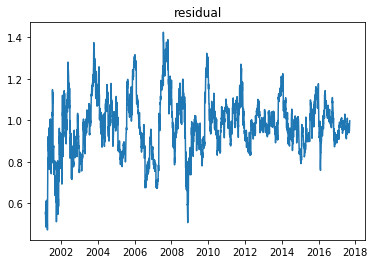

In [7]:
decomposition = seasonal_decompose(Data, 
                                   model='multiplicative', 
                                   freq=365)

plt.figure()
plt.title('trend')
plt.plot(decomposition.trend)
plt.show()

plt.figure()
plt.title('seasonal')
plt.plot(decomposition.seasonal)
plt.show()

plt.figure()
plt.title('residual')
plt.plot(decomposition.resid)
plt.show()

<Figure size 432x288 with 0 Axes>

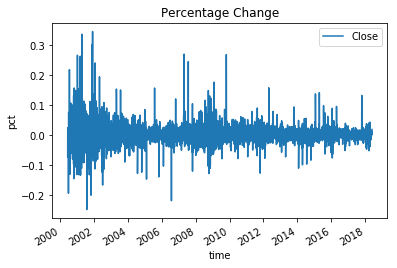

<Figure size 432x288 with 0 Axes>

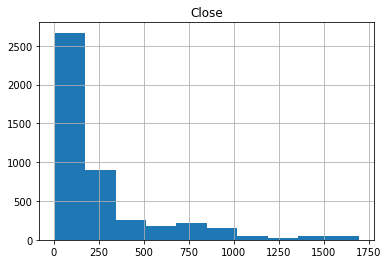

<Figure size 432x288 with 0 Axes>

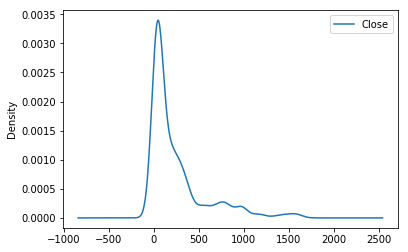

In [8]:
plt.figure()
Data.pct_change().plot()
plt.title('Percentage Change')
plt.xlabel('time')
plt.ylabel('pct')
plt.show()

plt.figure()
Data.hist()
plt.show()


plt.figure()
Data.plot(kind='kde')
plt.show()

Tain test split

$ \textbf{Y}(original series) = \textbf{Y}^{LINEAR} + \textbf{Y}^{NONLINEAR}$

$ N_{tr} :=$ size of training set

$ N_{ts} :=$ size of testing set

In [52]:
Y, lam = boxcox(Data['Close']) # to stationarize, using a square power transformation
print('lambda: ', lam)

lambda:  -0.05054507538198511


In [53]:
N = len(Y)
N_tr = int(N * 0.7)
N_ts = N - N_tr
print('Training size: ',N_tr)
print('Testing size: ',N_ts)

Y_tr = Y[0:N_tr:]
Y_ts = Y[N_tr:N:]

Training size:  3170
Testing size:  1359


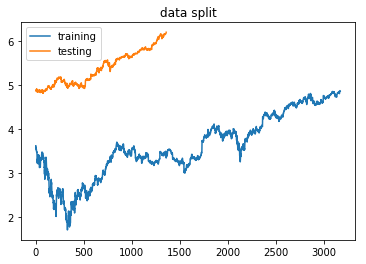

In [54]:
plt.title('data split')
plt.plot(Y_tr, label='training')
plt.plot(Y_ts, label='testing')
plt.legend(loc='upper left')


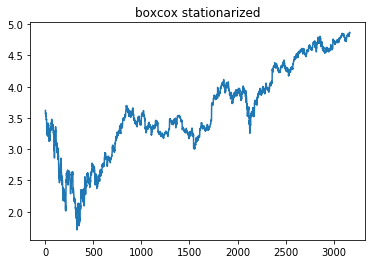

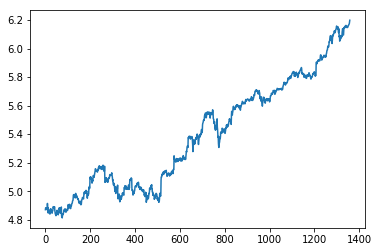

In [55]:
plt.figure()
plt.title('boxcox stationarized')
plt.plot(Y_tr)
plt.show()
plt.plot(Y_ts)
plt.show()

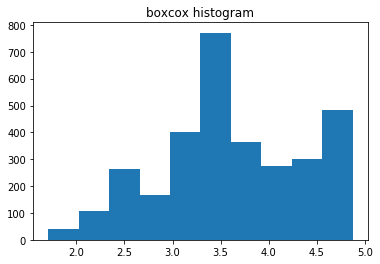

In [56]:
plt.figure
plt.title('boxcox histogram')
plt.hist(Y_tr)
plt.show()#seems to be just a log power

In [57]:
A_tr, D_tr = pywt.dwt(Y_tr, 'db1') # A is low frequency signal, D is high frequency signal
A_ts, D_ts = pywt.dwt(Y_ts, 'db1')

Y_tr_ap = pywt.idwt(A_tr, None, 'db1')
Y_tr_ds = pywt.idwt(None, D_tr, 'db1')

Y_ts_ap = pywt.idwt(A_ts, None, 'db1')
Y_ts_ds = pywt.idwt(None, D_ts, 'db1')

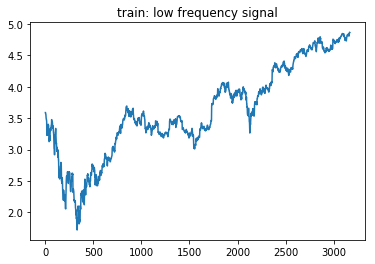

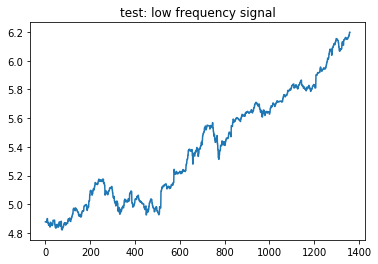

In [58]:
plt.title('train: low frequency signal')
plt.plot(Y_tr_ap)
plt.show()

plt.title('test: low frequency signal')
plt.plot(Y_ts_ap)
plt.show()

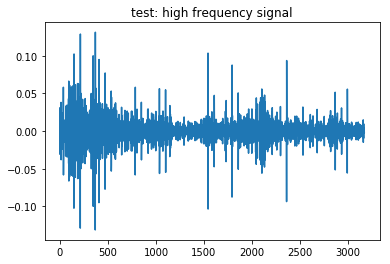

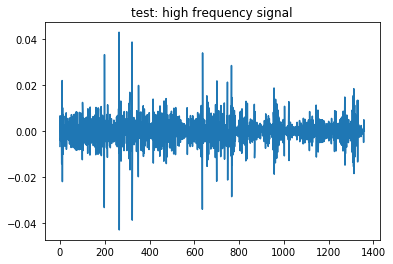

In [59]:
plt.title('test: high frequency signal')
plt.plot(Y_tr_ds)
plt.show()

plt.title('test: high frequency signal')
plt.plot(Y_ts_ds)
plt.show()

The low frequency signal will be used with an RNN. The high frequency signal will be used with ARIMA.

high frequency


C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


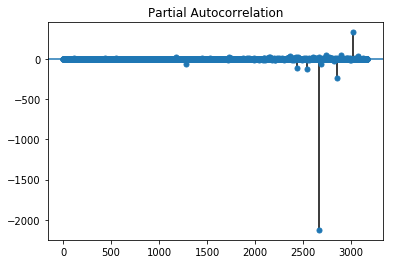

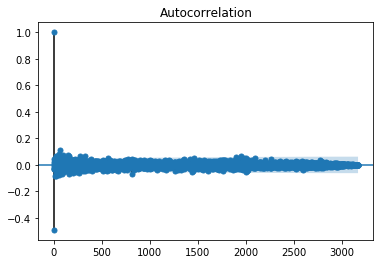

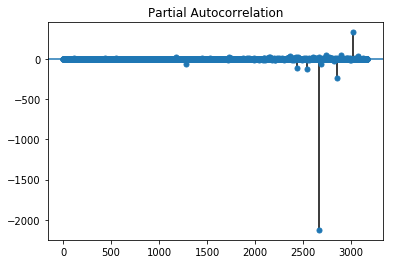

In [18]:
print('high frequency')
plot_acf(Y_tr_ds)
plot_pacf(Y_tr_ds)

Next is to perform an auto ARIMA on both low and high frequency signals. Aftwerwards, take the residuals of both and train on them with an ANN

In [19]:
arma_tr = auto_arima(Y_tr_ds, 
                     error_action='ignore', 
                     trace=1, 
                     stepwise=False,
                     n_fits=75,
                     random=True,
                     seasonal=True,
                     stationary=True,
                     m=7, 
                     max_p=20, 
                     max_q=20, 
                     n_jobs=-1,
                     max_order=100)
print(arma_tr.aic())

Total fit time: 220.151 seconds
-17683.26111181968


In [60]:
(p, d, q) = arma_tr.get_params()['order'] # i've seen (5,0,6) also work
alpha = p + d + q
print(arma_tr.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 3170
Model:             SARIMAX(2, 0, 4)x(1, 0, 1, 7)   Log Likelihood                8851.631
Date:                           Fri, 22 Feb 2019   AIC                         -17683.261
Time:                                   15:25:02   BIC                         -17622.646
Sample:                                        0   HQIC                        -17661.519
                                          - 3170                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.942e-06   1.06e-05     -0.747      0.455   -2.88e-05    1.29e-05
ar.L1         -1.3195      0.051    -25.702

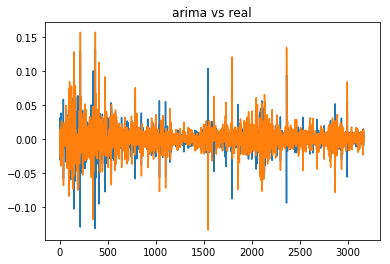

In [61]:
plt.plot(Y_tr_ds)
plt.plot(arma_tr.predict_in_sample(start=0,end=len(Y_tr_ds)))
plt.title('arima vs real')
plt.show()

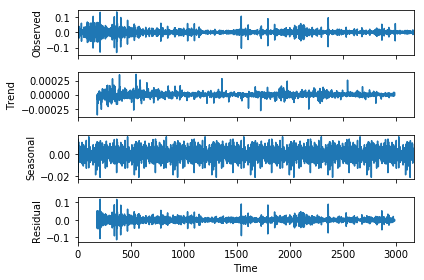

In [62]:
seasonal_decompose(Y_tr_ds, model='addative', freq=365).plot()
plt.show()

Text(0.5, 1.0, 'thirty days A forecast')

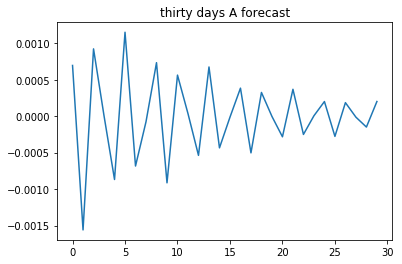

In [63]:
plt.plot(arma_tr.predict(n_periods=30))
plt.title('thirty days A forecast')

In [64]:
N_eff = N_tr - alpha
Y_eff = Y_tr_ds[alpha+1:N_tr] # effective training dataset
R = np.zeros(N_eff) # residual vector
Y_L = np.zeros(N_tr+N_ts) # linear series
Y_L_hat = np.zeros(N_eff+N_ts)
Y_ts_LIN = np.zeros(N_ts)
Y_L[:N_tr] = Y_tr_ds

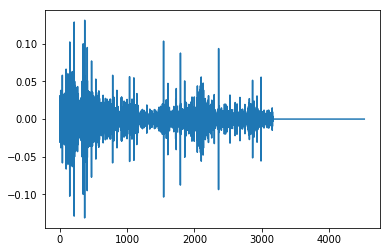

In [65]:
plt.plot(Y_L)

In [66]:
#arima.ARIMA(order=(8,0,7)).fit_predict(y=Y_L[k:alpha+k+50], n_periods=1)
R = arma_tr.resid()
Y_L_hat = arma_tr.predict(n_periods=N_ts)
Y_L[N_tr:] = arma_tr.predict(n_periods=N_ts)
Y_ts_LIN = Y_L_hat[N_eff+1:]

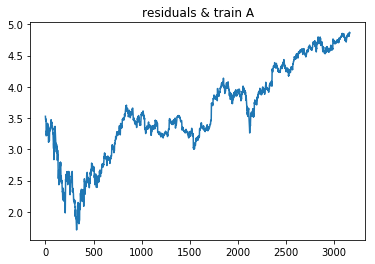

In [67]:
Y_hat_NLIN = np.zeros(N_ts)
Y_N = R[alpha:] + Y_tr_ap[alpha:]
plt.plot(Y_N)
plt.title('residuals & train A')
plt.show()

In [41]:
model = Sequential()
model.add(LSTM(256, input_shape=(1,1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [42]:
def DatasetCreation(dataset, TimeStep=1):
    DataX, DataY = [], []
    for i in range(len(dataset) - TimeStep -1):
        a = dataset[i:(i+TimeStep), 0]
        DataX.append(a)
        DataY.append(dataset[i+TimeStep,0])
    return np.array(DataX), np.array(DataY)

In [68]:
scaler = MinMaxScaler()
trainData = scaler.fit_transform(Y_N.reshape(-1, 1))
testData = scaler.transform(Y_ts_ap.reshape(-1, 1))
(TrainX, TrainY) = DatasetCreation(trainData[0:len(Y_N),:])
(TestX, TestY) = DatasetCreation(testData[0:len(Y_ts_ap),:])

TrainX = np.reshape(TrainX, (TrainX.shape[0], 1, TrainX.shape[1]))
TestX = np.reshape(TestX, (TestX.shape[0], 1, TestX.shape[1]))

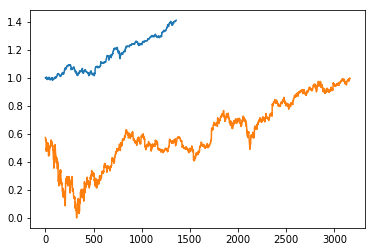

In [69]:
plt.plot(TestX.flatten())
plt.plot(TrainX.flatten())

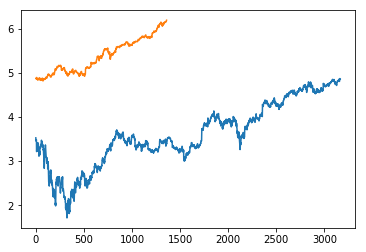

In [70]:
plt.plot(Y_N)
plt.plot(Y_ts_ap)

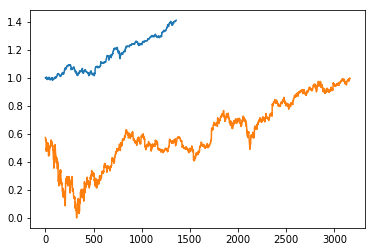

In [71]:
plt.plot(TestX.flatten())
plt.plot(TrainX.flatten())

In [47]:
model.fit(TrainX, TrainY, epochs=100, batch_size=1, verbose=0)

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


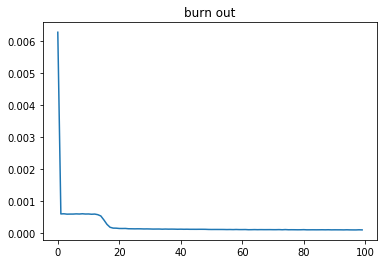

1.031846e-04


In [49]:
plt.plot(model.history.history['loss'])
plt.title('burn out')
plt.show()
print('%e' % np.min(model.history.history['loss']))

In [75]:
Y_ts_LIN = model.predict(TestX).flatten()
Y_ts_NLIN = arma_tr.predict(n_periods=N_ts-1)

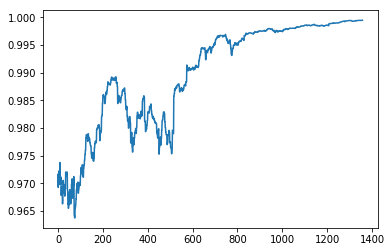

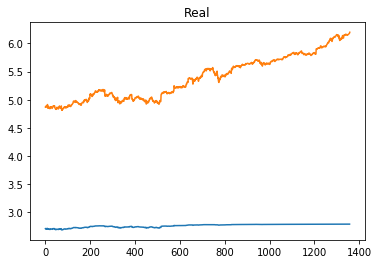

In [76]:
Y_ts_forecast = Y_ts_LIN + Y_ts_NLIN
plt.plot(Y_ts_forecast)
plt.show()
Y_forecast = inv_boxcox(Y_ts_forecast, lam)
plt.plot(Y_forecast)
plt.title('Forecast')
plt.plot(Y_ts)
plt.title('Real')
plt.show()

# Next Steps:
- debug this for where the data is acting weird
- Try using a seq-to-seq lstm using these resources:
    -https://weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/
    -https://towardsdatascience.com/time-series-forecasting-with-deep-stacked-unidirectional-and-bidirectional-lstms-de7c099bd918